<a href="https://colab.research.google.com/github/jainxy/retinanet_task/blob/master/Retinanet_finetune_selfDrivingDataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Installation and Setup environment

In [9]:
# This will automatically help adding GPU to the runtime
!nvidia-smi

Wed Apr 15 10:26:12 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.64.00    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   32C    P0    32W / 250W |    265MiB / 16280MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [10]:
# Install required packages

## keras-retinanet to use compatible pretrained retinanet backbone
!git clone https://github.com/fizyr/keras-retinanet.git
%cd keras-retinanet/
!pip install .
!python setup.py build_ext --inplace
%cd ../

## to use script for converting Udacity Self-driving dataset annotation into the COCO format.
!git clone https://github.com/jainxy/convert2COCO.git

# keras and tensorflow packages
!pip install --upgrade keras

Cloning into 'keras-retinanet'...
remote: Enumerating objects: 79, done.
remote: Counting objects: 100% (79/79), done.
remote: Compressing objects: 100% (63/63), done.
remote: Total 5699 (delta 24), reused 36 (delta 15), pack-reused 5620
Receiving objects: 100% (5699/5699), 14.07 MiB | 14.53 MiB/s, done.
Resolving deltas: 100% (3794/3794), done.
/content/keras-retinanet
Processing /content/keras-retinanet
  Created wheel for keras-retinanet: filename=keras_retinanet-0.5.1-cp36-cp36m-linux_x86_64.whl size=170860 sha256=cb2eee7a91587c3cf352edbf18d05a0861b0e617d3e878639b530c85a2796b1f
  Stored in directory: /root/.cache/pip/wheels/b2/9f/57/cb0305f6f5a41fc3c11ad67b8cedfbe9127775b563337827ba
  Created wheel for keras-resnet: filename=keras_resnet-0.1.0-py2.py3-none-any.whl size=13346 sha256=ff712be7d3547cbfdb5a17d3292483baacc117e86304a7bc7618a7918d9133db
  Stored in directory: /root/.cache/pip/wheels/80/dd/ac/842235b63dddac12faa4b48ebe58b8944e8c2e57c2e38dddb6
Successfully built keras-retina

In [24]:
# Import packages

%tensorflow_version  1.x  # Ensure tensorflow 2.x package is imported 
import tensorflow as tf  # Tensorflow 2.x package.
# import tensorflow_hub as hub  # Tensorflow Hub package to get pretrained models.
from tensorboard import notebook # tensorboard to manage in-notebook Tensorboard instances
print(tf.version)
# %load_ext tensorboard # load the TensorBoard notebook extension

import keras

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
import seaborn as sns
sns.set(style='whitegrid', palette='muted', font_scale=1.5)

import cv2
from pycocotools.coco import COCO
from pycocotools.cocoeval import COCOeval
from PIL import Image
from google.colab import drive

import os, time, sys, glob, subprocess, pathlib # !!! clean before submission !!!
import urllib
import csv, json
from pprint import pprint

from keras_retinanet import models
from keras_retinanet.utils.image import read_image_bgr, preprocess_image, resize_image
from keras_retinanet.utils.visualization import draw_box, draw_caption
from keras_retinanet.utils.colors import label_color

`%tensorflow_version` only switches the major version: 1.x or 2.x.
You set: `1.x  # Ensure tensorflow 2.x package is imported`. This will be interpreted as: `1.x`.


TensorFlow is already loaded. Please restart the runtime to change versions.
<module 'tensorflow._api.v1.version' from '/tensorflow-1.15.2/python3.6/tensorflow_core/_api/v1/version/__init__.py'>


In [12]:
print("GPUs available - {}".format(tf.test.is_gpu_available()))

GPUs available - True


#### defines/functions

In [0]:
def check_create_path(path):
  '''
  Check if path exists else create
  '''
  if not os.path.exists(path):
    os.makedirs(path)
    print("Created Path - ", path)
  else:
    print("Path - ", path, " exists!")

def draw_bbox(img, bbox, color, thickness=20, label = None):
    """ Draws a bounding-box on an image with a given color.
    # Arguments
        img     : The image to draw on.
        bbox       : A list of 4 elements (x1, y1, x2, y2).
        color     : The color of the box.
        thickness : The thickness of the lines to draw a box with.
    """
    bbox = np.array(bbox).astype(int)
    print(bbox)
    cv2.rectangle(img, (bbox[0], bbox[1]), (bbox[2], bbox[3]), color, thickness, cv2.LINE_AA)
    if label is not None:
        font = cv2.FONT_HERSHEY_PLAIN
        fontColor = (255, 255, 255)
        cv2.putText(img, label.upper(), (bbox[0], bbox[1] - 10), font, 8, fontColor, 15)

def disp_objects_img(img_row):
    img_name = img_row.Frame
    img_path = os.path.join(img_name)
    bbox = [img_row.xmin, img_row.ymin, img_row.xmax, img_row.ymax]
    label = img_row.Label
    img = cv2.imread(img_path)

    img_draw = img.copy()
    img_draw = cv2.cvtColor(img_draw, cv2.COLOR_BGR2RGB)

    draw_bbox(img_draw, bbox, color=(255, 255, 0), label=label)

    plt.axis('off')
    plt.imshow(img_draw)
    plt.show()

def mount_gdrive():
  drive.mount('/content/gdrive')
  return "/content/gdrive/My Drive/"

# functions for inference
def predict(image, model):
  image = preprocess_image(image.copy())
  image, scale = resize_image(image)

  boxes, scores, labels = model.predict_on_batch(np.expand_dims(image, axis=0))
  boxes /= scale

  return boxes, scores, labels

def draw_detections(image, boxes, scores, labels, score_thresh):
  for box, score, label in zip(boxes[0], scores[0], labels[0]):
    if score < score_thresh:
        break

    color = label_color(label+8)

    b = box.astype(int)
    draw_box(image, b, color=color, thickness=10)

    caption = "{} {:.3f}".format(labels_to_names[label], score)
    draw_caption(image, b, caption)

def show_detected_objects(image_row, data_dir, model, score_thresh):
  img_path = os.path.join(data_dir, image_row.Frame)
  
  image = cv2.imread(img_path)

  boxes, scores, labels = predict(image, model)

  draw = image.copy()
  draw = cv2.cvtColor(draw, cv2.COLOR_BGR2RGB)

  true_box = [
    image_row.xmin, image_row.ymin, image_row.xmax, image_row.ymax
  ]
  draw_box(draw, true_box, color=(255, 255, 0))

  draw_detections(draw, boxes, scores, labels, score_thresh)

  plt.axis('off')
  plt.imshow(draw)
  plt.show()

#### global/constants/flags

In [0]:
STORAGE_USE_GDRIVE = False  # Use google-drive for persistent storage and training checkpoints

_URL_IMG = "https://s3.amazonaws.com/udacity-sdc/annotations/object-detection-crowdai.tar.gz"
_URL_LABEL = "https://raw.githubusercontent.com/udacity/self-driving-car/master/annotations/labels_crowdai.csv"

CLASS_NAMES = ["Car", "Truck", "Pedestrian"]
# AUTOTUNE = tf.data.experimental.AUTOTUNE

THRES_SCORE = 0.4

# Set random-seed for reproducibility
RANDOM_SEED = 101
np.random.seed(RANDOM_SEED)
tf.random.set_random_seed(RANDOM_SEED)

#### Select storage location - Local or Google-drive

In [15]:
if STORAGE_USE_GDRIVE:
  drive_path = mount_gdrive()
else:  # Use Colab VM storage
  drive_path = "/content/"
data_path = os.path.join(drive_path, 'dataset/')
check_create_path(data_path)

Path -  /content/dataset/  exists!


# Data
## Download -- Clean -- Prepare

#### Download and extract the dataset

In [16]:
img_tar_path = os.path.join(data_path, "object-detection-crowdai.tar.gz")
img_dir_path = os.path.join(data_path, "object-detection-crowdai/")
ann_csv_path = os.path.join(data_path, "labels_crowdai.csv")

# check and download the Image-datset tar file
if not os.path.exists(img_tar_path):
  print("Downloading tar file of image dataset ...")
  !wget -c -P "{data_path}" {_URL_IMG}
else:
  print("Tar file of image dataset exists at ", img_tar_path)
# extract tar-file
if not os.path.exists(img_dir_path):
  print("Extracting tar file of image dataset ...")
  !tar -xvf "{img_tar_path}" -C "{data_path}"
else:
  print("Extracted image dataset exists at ", img_dir_path)
img_dir_path = pathlib.Path(img_dir_path)

# check and download the Annotation CSV file
if not os.path.exists(ann_csv_path):
  print("Downloading Annotation CSV file ...")
  !wget -c -P "{data_path}" {_URL_LABEL}
else:
  print("Annotation CSV file exists at ", ann_csv_path)
!ls -l

Tar file of image dataset exists at  /content/dataset/object-detection-crowdai.tar.gz
Extracted image dataset exists at  /content/dataset/object-detection-crowdai/
Annotation CSV file exists at  /content/dataset/labels_crowdai.csv
total 16
drwxr-xr-x  3 root root 4096 Apr 15 10:26 convert2COCO
drwxr-xr-x  3 root root 4096 Apr 15 10:25 dataset
drwxr-xr-x 10 root root 4096 Apr 15 10:26 keras-retinanet
drwxr-xr-x  1 root root 4096 Apr  3 16:24 sample_data


In [17]:
img_l = img_dir_path.glob('*.jpg')
nImg = len(list(img_l))
print("Number of images - %d" % nImg)

Number of images - 9420


#### Create COCO version of the ground-truth annotation file

In [28]:
%cd "{drive_path}"
!cp "convert2COCO/udacity_self_driving_to_coco.py" "{data_path}"
%cd "{data_path}"
!python udacity_self_driving_to_coco.py
anno_coco_fpath = os.path.abspath("labels_crowdai_coco.json")
print("Generated COCO-format JSON annotation file at ", anno_coco_fpath)
%cd -

/content
/content/dataset
(72064, 7)
[{'id': 1, 'name': 'Car', 'supercategory': 'none'},
 {'id': 2, 'name': 'Truck', 'supercategory': 'none'},
 {'id': 3, 'name': 'Pedestrian', 'supercategory': 'none'}]
Number of images - 9218
[{'file_name': '1479498371963069978.jpg',
  'height': 1200,
  'id': 1479498371963069978,
  'width': 1920},
 {'file_name': '1479498372942264998.jpg',
  'height': 1200,
  'id': 1479498372942264998,
  'width': 1920},
 {'file_name': '1479498373962951201.jpg',
  'height': 1200,
  'id': 1479498373962951201,
  'width': 1920},
 {'file_name': '1479498374962942172.jpg',
  'height': 1200,
  'id': 1479498374962942172,
  'width': 1920},
 {'file_name': '1479498375942206592.jpg',
  'height': 1200,
  'id': 1479498375942206592,
  'width': 1920}]
Number of Annotations - 72064
[{'bbox': [785, 533, 120, 111],
  'category_id': 1,
  'id': 1,
  'image_id': 1479498371963069978},
 {'bbox': [89, 551, 202, 129],
  'category_id': 1,
  'id': 2,
  'image_id': 1479498371963069978},
 {'bbox': [2

#### Prepare dataset for training

In [18]:
%cd {data_path}
!ls
IMG_DIR = "object-detection-crowdai"
anno_coco_file = "labels_crowdai_coco.json"
# Read existing csv as dataframe
df_anno = pd.read_csv("labels_crowdai.csv")
# Filter dataset for incorrect labelling
df_anno = df_anno[(df_anno['xmax']>df_anno['xmin']) & (df_anno['ymax']>df_anno['ymin'])]
print(df_anno.shape)
# transform data as per the requiremnts of training script
col_names = ['Frame', 'xmin', 'ymin', 'xmax', 'ymax', 'Label']
df_anno = df_anno.reindex(columns=col_names)
df_anno['Frame'] = df_anno['Frame'].apply(lambda x: os.path.join(IMG_DIR, x))

df_anno.head()

/content/dataset
labels_crowdai.csv  object-detection-crowdai  object-detection-crowdai.tar.gz
(72060, 7)


,Frame,xmin,ymin,xmax,ymax,Label
0,object-detection-crowdai/1479498371963069978.jpg,785,533,905,644,Car
1,object-detection-crowdai/1479498371963069978.jpg,89,551,291,680,Car
2,object-detection-crowdai/1479498371963069978.jpg,268,546,383,650,Car
3,object-detection-crowdai/1479498371963069978.jpg,455,522,548,615,Truck
4,object-detection-crowdai/1479498371963069978.jpg,548,522,625,605,Truck


#### Split dataset into training-testing folds

In [0]:
train_df, test_df = train_test_split(
  df_anno, 
  test_size=0.2, 
  random_state=RANDOM_SEED
)

#### Display some samples

[  0 544 299 789]


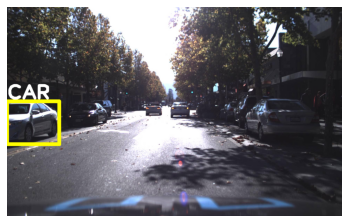

[893 533 923 563]


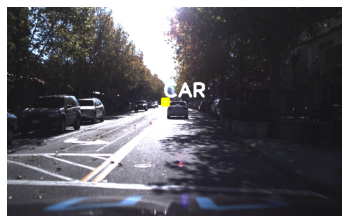

In [20]:
disp_objects_img(test_df.iloc[31])
disp_objects_img(train_df.iloc[18])

#### Save annotations as csv files for the training script

In [21]:
ANNOTATIONS_TRAIN_FILE = 'annotations_train.csv'
ANNOTATIONS_TEST_FILE = 'annotations_test.csv'
CLASSES_FILE = 'classes.csv'
train_df.to_csv(ANNOTATIONS_TRAIN_FILE, index=False, header=None)
test_df.to_csv(ANNOTATIONS_TEST_FILE, index=False, header=None)

classes = sorted(df_anno.Label.unique())
with open(CLASSES_FILE, 'w') as f:
  for i, line in enumerate(sorted(classes)):
    f.write('{},{}\n'.format(line,i))

ANNOTATIONS_TRAIN_FILEPATH = os.path.join(os.getcwd(), ANNOTATIONS_TRAIN_FILE)
ANNOTATIONS_TEST_FILEPATH = os.path.join(os.getcwd(), ANNOTATIONS_TEST_FILE)
CLASSES_FILEPATH = os.path.join(os.getcwd(), CLASSES_FILE)

## List files and head-content of the csv files
!ls
%cd /content/
!head "{ANNOTATIONS_TRAIN_FILEPATH}" -n 3
!head "{ANNOTATIONS_TEST_FILEPATH}" -n 3
!head "{CLASSES_FILEPATH}"

annotations_test.csv   classes.csv	   object-detection-crowdai
annotations_train.csv  labels_crowdai.csv  object-detection-crowdai.tar.gz
/content
object-detection-crowdai/1479503944322290167.jpg,650,568,695,607,Car
object-detection-crowdai/1479504559883215179.jpg,605,564,681,630,Car
object-detection-crowdai/1479502077716170613.jpg,508,580,610,652,Car
object-detection-crowdai/1479505939475902144.jpg,328,590,364,626,Car
object-detection-crowdai/1479498377463264578.jpg,1560,593,1637,653,Car
object-detection-crowdai/1479504698892976645.jpg,361,290,1238,1049,Car
Car,0
Pedestrian,1
Truck,2


# Training

#### Download pretrained retinanet backbone

In [22]:
snapshot_path = os.path.join(drive_path, 'models/')
os.makedirs(snapshot_path, exist_ok=True)
PRETRAINED_MODEL = os.path.join(snapshot_path, 'pretrained_model.h5')

URL_MODEL = 'https://github.com/fizyr/keras-retinanet/releases/download/0.5.1/resnet50_coco_best_v2.1.0.h5'
if not os.path.exists(PRETRAINED_MODEL):
  urllib.request.urlretrieve(URL_MODEL, PRETRAINED_MODEL)
  print('Downloaded pretrained model to ' + PRETRAINED_MODEL)
else:
  print('Pretrained model present at ' + PRETRAINED_MODEL)

# Tensorboard logs directory
tblogs_path = os.path.join(drive_path, 'tblogs/')
os.makedirs(tblogs_path, exist_ok=True)

Downloaded pretrained model to /content/models/pretrained_model.h5


#### Perform training

In [23]:
%cd keras-retinanet/

!keras_retinanet/bin/train.py --freeze-backbone --random-transform --weights "{PRETRAINED_MODEL}" \
--batch-size 8 --steps 1000 --epochs 1 --snapshot-path "{snapshot_path}" --weighted-average \
--tensorboard-dir "{tblogs_path}" csv "{ANNOTATIONS_TRAIN_FILEPATH}" "{CLASSES_FILEPATH}" 

/content/keras-retinanet
Using TensorFlow backend.
Creating model, this may take a second...
Instructions for updating:
If using Keras pass *_constraint arguments to layers.

/usr/local/lib/python3.6/dist-packages/keras/engine/saving.py:1319: UserWarning: Skipping loading of weights for layer classification_submodel due to mismatch in shape ((3, 3, 256, 27) vs (720, 256, 3, 3)).
  weight_values[i].shape))
/usr/local/lib/python3.6/dist-packages/keras/engine/saving.py:1319: UserWarning: Skipping loading of weights for layer classification_submodel due to mismatch in shape ((27,) vs (720,)).
  weight_values[i].shape))
2020-04-15 10:27:19.327287: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcuda.so.1
2020-04-15 10:27:19.329821: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:983] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2020-04-15 10:27

#### Mount google-drive to backup the artifacts

In [29]:
gdpath = mount_gdrive()
print(gdpath)
!cp -r "{tblogs_path}" "{gdpath}"
!cp -r "{snapshot_path}" "{gdpath}"
%cd "{drive_path}"

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive
/content/gdrive/My Drive/


# Inference and Visualization

### Load trained model and convert for inference

In [30]:
!ls "{snapshot_path}"

pretrained_model.h5  resnet50_csv_01.h5


In [33]:
model_path = os.path.join(snapshot_path, sorted(os.listdir(snapshot_path), reverse=True)[0])
print(model_path)

# Load model from file and convert for inference
model = models.load_model(model_path, backbone_name='resnet50')
model = models.convert_model(model)

labels_to_names = pd.read_csv(CLASSES_FILEPATH, header=None).T.loc[0].to_dict()
print(labels_to_names)

/content/models/resnet50_csv_01.h5
tracking <tf.Variable 'Variable_5:0' shape=(9, 4) dtype=float32> anchors
tracking <tf.Variable 'Variable_6:0' shape=(9, 4) dtype=float32> anchors
tracking <tf.Variable 'Variable_7:0' shape=(9, 4) dtype=float32> anchors
tracking <tf.Variable 'Variable_8:0' shape=(9, 4) dtype=float32> anchors
tracking <tf.Variable 'Variable_9:0' shape=(9, 4) dtype=float32> anchors


#### Visualize Inference on few samples

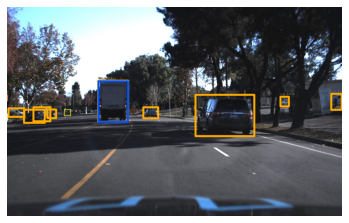

In [54]:
show_detected_objects(test_df.iloc[0], data_path, model, THRES_SCORE)

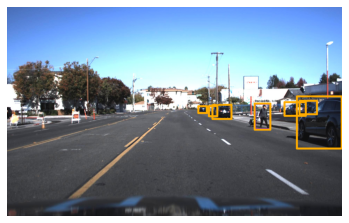

In [55]:
show_detected_objects(test_df.iloc[4], data_path, model, THRES_SCORE)

# Deploy

### Prepare and save model for TF-serving

#### Define a destination path for the model

In [57]:
print(model)
MODEL_EXPORT_DIR = os.path.join(drive_path, 'retinanet')
MODEL_VERSION = 1
MODEL_EXPORT_PATH = os.path.join(MODEL_EXPORT_DIR, str(MODEL_VERSION))
print("Model dir: ", MODEL_EXPORT_PATH)

Model dir:  /content/retinanet/1


#### Save the model to the MODEL_EXPORT_PATH

In [58]:
# Print the input tensors of the model
print(model.inputs)
# Create an input mapping, and name each of the input tensors.
input_names = ['image']
name_to_input = {name: t_input for name, t_input in zip(input_names, model.inputs)}
print(name_to_input)

[<tf.Tensor 'input_1_1:0' shape=(?, ?, ?, 3) dtype=float32>]
{'image': <tf.Tensor 'input_1_1:0' shape=(?, ?, ?, 3) dtype=float32>}


In [59]:
tf.saved_model.simple_save(
    keras.backend.get_session(),
    MODEL_EXPORT_PATH,
    inputs=name_to_input,
    outputs={t.name: t for t in model.outputs})

Instructions for updating:
This function will only be available through the v1 compatibility library as tf.compat.v1.saved_model.simple_save.
Instructions for updating:
This function will only be available through the v1 compatibility library as tf.compat.v1.saved_model.utils.build_tensor_info or tf.compat.v1.saved_model.build_tensor_info.
INFO:tensorflow:Assets added to graph.
INFO:tensorflow:No assets to write.
INFO:tensorflow:SavedModel written to: /content/retinanet/1/saved_model.pb


In [60]:
# Show the saved resources
!ls -lh "{MODEL_EXPORT_PATH}"
!ls -lh "{MODEL_EXPORT_PATH}/variables"

total 3.3M
-rw-r--r-- 1 root root 3.3M Apr 15 12:03 saved_model.pb
drwxr-xr-x 2 root root 4.0K Apr 15 12:03 variables
total 475M
-rw-r--r-- 1 root root 475M Apr 15 12:03 variables.data-00000-of-00001
-rw-r--r-- 1 root root  31K Apr 15 12:03 variables.index


#### Mount google-drive to backup the servable model

In [61]:
gdpath = mount_gdrive()
print(gdpath)
!cp -r "{MODEL_EXPORT_DIR}" "{gdpath}"
%cd "{drive_path}"

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
/content/gdrive/My Drive/
/content


# Tensorboard
Upload TB logs to tensorboard.dev for hosting publically 

In [0]:
!tensorboard dev upload --logdir "keras-retinanet/tblogs" \
  --name "Training Retinanet on Udacity Self-driving Car dataset" \
  --description "Training results from https://colab.research.google.com/github/jainxy/retinanet_task/blob/master/Retinanet_finetune_selfDrivingDataset.ipynb"

!tensorboard dev list